# Genetic Algorihm for UPC&S

## Import packages

In [1]:
import random
from numpy.random import randint
from numpy.random import rand
import pandas as pd
import datetime
import numpy as np
from tqdm import tqdm
pd.set_option('display.max_row', 100)


## Read Data & Assign the variables

In [2]:
# file read
machine_info = pd.read_csv('machine_info.csv')
order_info = pd.read_csv('order_info.csv')

# 전처리 (1) coulmn name 변경
order_info = order_info.rename(columns={
    '영업납기':'date',
    '중산도면': 'item',
    '단가': 'cost',
    '수량' :'qty',
    '선급': 'urgent'
})
order_info = order_info[['date', 'item', 'cost', 'qty', 'urgent']]

machine_info = machine_info.rename(columns={
    'JSDWG':'item',
    'MCNO':'machine',
    'AVG_CT': 'capacity' 
})
machine_info = machine_info[['item', 'machine', 'capacity']]


# 전처리 (2) 분석을 위한 데이터 처리
order_info['urgent'] = order_info['urgent'].fillna(0)
for i in range(len(order_info)):
    if order_info.loc[i, 'urgent']!=0:
        order_info.loc[i, 'urgent'] = 1

# 전처리 (3) date type 부여
order_info['date'] = order_info['date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))

In [3]:
order_info.head()

,date,item,cost,qty,urgent
0,2021-05-13,K04033,25870,318,1
1,2021-05-24,K04031,16229,383,1
2,2021-05-30,051718,8333,19,0
3,2021-06-03,056984,36533,4,0
4,2021-06-18,057791,45500,196,1


In [4]:
order_info.value_counts()

date        item    cost    qty  urgent
2021-02-10  S00341  2990    500  0         1
2021-07-01  057387  16100   144  1         1
2021-07-07  K03894  60000   46   1         1
2021-07-06  K03899  22005   396  1         1
            059988  166250  24   1         1
                                          ..
2021-06-17  053695  33984   6    0         1
2021-06-15  Z00807  10450   300  0         1
            K03115  26719   30   0         1
                            28   0         1
2021-09-15  Z00807  10450   325  0         1
Length: 127, dtype: int64

In [5]:
machine_info.head()

,item,machine,capacity
0,050060,433.0,1.08
1,050093,404.0,7.13
2,050093,408.0,4.67
3,050093,410.0,4.50
4,050093,416.0,3.92


In [6]:
machine_info.value_counts()

item    machine  capacity
050060  433.0    1.08        1
K00347  404.0    11.05       1
K00337  438.0    40.00       1
        437.0    7.13        1
        410.0    8.77        1
                            ..
058398  408.0    4.61        1
        404.0    4.17        1
058396  438.0    7.08        1
        434.0    6.30        1
Z01415  409.0    9.50        1
Length: 21149, dtype: int64

# 데이터 유효성 검사

In [7]:
# 1. 완전성 (Completeness)
perc = 30
df_set = {'order_info':order_info, 'machine_info':machine_info}
for df_name in list(df_set):
    print(f'DataFrame name: {df_name}')
    df = df_set[df_name]
    print('[step 1-1]')
    print(round(df.isnull().sum()/len(df)*100, 2))
    print('[step 1-2]')
    print(df.isnull().sum()/len(df)*100>perc)
    print('[step 2-1]')
    print(df.isnull().head())
    print('[step 2-2]')
    print(df.isnull().sum())
    print('[step 2-3]')
    cmpt_len = df.isnull().sum().sum()
    print(cmpt_len)


print("결측치 = %d개 \n완전성 지수 : %.2f%% "%(cmpt_len,(1-cmpt_len/len(df))*100))

DataFrame name: order_info
[step 1-1]
date      0.0
item      0.0
cost      0.0
qty       0.0
urgent    0.0
dtype: float64
[step 1-2]
date      False
item      False
cost      False
qty       False
urgent    False
dtype: bool
[step 2-1]
    date   item   cost    qty  urgent
0  False  False  False  False   False
1  False  False  False  False   False
2  False  False  False  False   False
3  False  False  False  False   False
4  False  False  False  False   False
[step 2-2]
date      0
item      0
cost      0
qty       0
urgent    0
dtype: int64
[step 2-3]
0
DataFrame name: machine_info
[step 1-1]
item        0.00
machine     0.01
capacity    0.00
dtype: float64
[step 1-2]
item        False
machine     False
capacity    False
dtype: bool
[step 2-1]
    item  machine  capacity
0  False    False     False
1  False    False     False
2  False    False     False
3  False    False     False
4  False    False     False
[step 2-2]
item        0
machine     2
capacity    0
dtype: int64
[step 2-3]

In [8]:
# 2. 유일성 (Uniqueness)

check_unique = order_info[
    ['date', 'item', 'urgent']
    ].value_counts().reset_index()
perc_check_unique_item_urgent_info = round(
    (len(check_unique)-len(check_unique[check_unique[0]>1]))
    /len(check_unique)*100, 2)

check_unique = machine_info[
    ['item', 'machine']
    ].value_counts().reset_index()
perc_check_unique_machine_info = round(
    (len(check_unique)-len(check_unique[check_unique[0]>1]))
    /len(check_unique)*100, 2)

print(f'The percentage of uniqueness for date<->item<->cost<->urgent : {perc_check_unique_item_urgent_info}')
print(f'The percentage of uniqueness for item<->machine : {perc_check_unique_machine_info}')
print("유일성 지수 : %.2f%% "%((perc_check_unique_machine_info+perc_check_unique_item_urgent_info)/2))

The percentage of uniqueness for date<->item<->cost<->urgent : 97.58
The percentage of uniqueness for item<->machine : 100.0
유일성 지수 : 98.79% 


In [9]:
check_unique = order_info[
    ['date', 'item', 'urgent']
    ].value_counts().reset_index()
check_unique

,date,item,urgent,0
0,2021-07-09,057386,1,2
1,2021-07-09,057387,1,2
2,2021-06-15,K03115,0,2
3,2021-02-10,S00341,0,1
4,2021-07-07,K03894,1,1
...,...,...,...,...
119,2021-06-17,060711,0,1
120,2021-06-17,053695,0,1
121,2021-06-15,Z00807,0,1
122,2021-06-15,063414,0,1


In [10]:
check_unique = machine_info[
    ['item', 'machine']
    ].value_counts().reset_index()
check_unique

,item,machine,0
0,050060,433.0,1
1,K00347,404.0,1
2,K00337,438.0,1
3,K00337,437.0,1
4,K00337,410.0,1
...,...,...,...
21144,058398,408.0,1
21145,058398,404.0,1
21146,058396,438.0,1
21147,058396,434.0,1


In [11]:
perc_check_unique_item_urgent_info = round(
    (len(check_unique)-len(check_unique[check_unique[0]>1]))
    /len(check_unique)*100, 2)
print(f'The percentage of uniqueness for date<->item<->cost<->urgent : {perc_check_unique_item_urgent_info}')


The percentage of uniqueness for date<->item<->cost<->urgent : 100.0


In [12]:
# 3. 유효성 (Validity)

print('order_info case')
df = order_info
c_lb = df['cost'] >= 0
c_ub = df['cost'] <= 1000000
q_lb = df['qty'] >= 0
q_ub = df['qty'] <= 1000000
u_lb = df['urgent'] >= 0
u_ub = df['urgent'] <= 1
vald_df = df[c_lb & c_ub & q_lb & q_ub & u_lb & u_ub]
print(f'[Step 1] 데이터 범위를 벗어난 데이터 수: {len(df) - len(vald_df)}')

d0 = pd.Timestamp(datetime.date(2021,1,31))  #date 객체1
d1 = pd.Timestamp(datetime.date(2021,10,31))  #date 객체2
con1 = vald_df['date'] >= d0
con2 = vald_df['date'] <= d1
vald_df = vald_df[con1&con2]
print(f'[Step 2] 수집된 날짜를 벗어나는 데이터 수: {len(df) - len(vald_df)}')

vald_df['date'] = vald_df['date'].apply(lambda x: isinstance(x, datetime.datetime))
vald_df['item'] = vald_df['item'].apply(lambda x: isinstance(x, str))
vald_df['cost'] = vald_df['cost'].apply(lambda x: isinstance(x, int))
vald_df['qty'] = vald_df['qty'].apply(lambda x: isinstance(x, int))
vald_df['urgent'] = vald_df['urgent'].apply(lambda x: isinstance(x, int))
print(f'[Step 3] 데이터 형식을 벗어나는 데이터 수: {len(df) - len(vald_df)}')

vald_df[
    (vald_df['date']==True)
    &(vald_df['item']==True)
    &(vald_df['cost']==True)
    &(vald_df['qty']==True)
    &(vald_df['urgent']==True)
    ]
vald_len = len(vald_df)
item_vald = vald_len/len(df)*100
print("order_info 유효성 지수 : %.2f%% "%(item_vald)) 

print('machine_info case')
df = machine_info
cap_lb = df['capacity'] >= 0
cap_ub = df['capacity'] <= 1000000
vald_df = df[cap_ub & cap_lb]
print(f'[Step 1] 데이터 범위를 벗어난 데이터 수: {len(df) - len(vald_df)}')

vald_df['item'] = vald_df['item'].apply(lambda x: isinstance(x, str))
vald_df['machine'] = vald_df['machine'].apply(lambda x: isinstance(x, str))
vald_df['capacity'] = vald_df['capacity'].apply(lambda x: float(x) if isinstance(x, int)==True else x)
vald_df['capacity'] = vald_df['capacity'].apply(lambda x: isinstance(x, float))
print(f'[Step 3] 데이터 형식을 벗어나는 데이터 수: {len(df) - len(vald_df)}')

vald_df[
    (vald_df['item']==True)
    &(vald_df['machine']==True)
    &(vald_df['capacity']==True)
    ]
vald_len = len(vald_df)
machine_vald = vald_len/len(df)*100
print("machine_info 유효성 지수 : %.2f%% "%(machine_vald)) 

print("유효성 지수 : %.2f%% "%((item_vald + machine_vald)/2)) 


order_info case
[Step 1] 데이터 범위를 벗어난 데이터 수: 0
[Step 2] 수집된 날짜를 벗어나는 데이터 수: 0
[Step 3] 데이터 형식을 벗어나는 데이터 수: 0
order_info 유효성 지수 : 100.00% 
machine_info case
[Step 1] 데이터 범위를 벗어난 데이터 수: 0
[Step 3] 데이터 형식을 벗어나는 데이터 수: 0
machine_info 유효성 지수 : 100.00% 
유효성 지수 : 100.00% 


In [13]:
# 데이터 형식 확인
print('[Step 2] 데이터 형식을 벗어나는 데이터 수')
check_validity = []
check = len(order_info) - sum(order_info['date'].apply(lambda x: isinstance(x, datetime.datetime)))
check_validity.append(['order_info | date (datetime)', check])
check = len(order_info) - sum(order_info['item'].apply(lambda x: isinstance(x, str)))
check_validity.append(['order_info | item (str)', check])
check = len(order_info) - sum(order_info['cost'].apply(lambda x: isinstance(x, int)))
check_validity.append(['order_info | cost (int)', check])
check = len(order_info) - sum(order_info['qty'].apply(lambda x: isinstance(x, int)))
check_validity.append(['order_info | qty (int)', check])
check = len(order_info) - sum(order_info['urgent'].apply(lambda x: isinstance(x, int)))
check_validity.append(['order_info | urgent (int)', check])

check = round(
    ( len(machine_info)- sum(machine_info['item'].apply(lambda x: isinstance(x, str))
    ))/len(machine_info)*100, 3)
check_validity.append(['machine_info | item (str)', check])
check = round(
    (len(machine_info) - sum(machine_info['machine'].apply(lambda x: isinstance(x, str))
    ))/len(machine_info)*100, 3)
check_validity.append(['machine_info | machine (str)', check])
check = 0
for i in machine_info['capacity']:
    if isinstance(i, float):
        if isinstance(i, int):
            check += 0
check_validity.append(['machine_info | capacity (float)', round(check/len(machine_info)*100,3)])

pd.DataFrame(check_validity)




[Step 2] 데이터 형식을 벗어나는 데이터 수


,0,1
0,order_info | date (datetime),0.0
1,order_info | item (str),0.0
2,order_info | cost (int),0.0
3,order_info | qty (int),0.0
4,order_info | urgent (int),0.0
5,machine_info | item (str),0.0
6,machine_info | machine (str),100.0
7,machine_info | capacity (float),0.0


In [14]:
# 4. 일관성 
df = order_info
vald_df = df[['item']].copy()
vald_df['check'] = vald_df['item'].isin(set(machine_info['item']))
print("일관성 지수 : %.2f%% "%(sum(vald_df['check'])/len(df)*100)) 
vald_df


일관성 지수 : 100.00% 


,item,check
0,K04033,True
1,K04031,True
2,051718,True
3,056984,True
4,057791,True
...,...,...
122,Z00807,True
123,069559,True
124,K00614,True
125,K04037,True


In [15]:
machine_info

,item,machine,capacity
0,050060,433.0,1.08
1,050093,404.0,7.13
2,050093,408.0,4.67
3,050093,410.0,4.50
4,050093,416.0,3.92
...,...,...,...
21146,Z01387,439.0,2.32
21147,Z01387,440.0,2.34
21148,Z01388,433.0,4.16
21149,Z01407,408.0,3.00


# 전처리



In [16]:
# nan값 처리
n_before_preprocess = len(machine_info)
machine_info.dropna(axis=0, inplace=True)
n_after_preprocess = len(machine_info)
print(f'Machine_info : nan 값 제거 ({n_before_preprocess} row --> {n_after_preprocess} row, {round(((n_before_preprocess-n_after_preprocess)/n_before_preprocess*100), 3)}% 삭제)')

n_before_preprocess = len(order_info)
order_info = order_info[['date', 'item', 'cost', 'qty', 'urgent']]
order_info.dropna(axis=0, inplace=True)
n_after_preprocess = len(order_info)
print(f'order_info : nan 값 제거 ({n_before_preprocess} row --> {n_after_preprocess} row, {round(((n_before_preprocess-n_after_preprocess)/n_before_preprocess*100), 3)}% 삭제)')


Machine_info : nan 값 제거 (21151 row --> 21149 row, 0.009% 삭제)
order_info : nan 값 제거 (127 row --> 127 row, 0.0% 삭제)


In [17]:
order_info[['date', 'item', 'cost']].value_counts().head()


date        item    cost 
2021-07-09  057386  24418    2
            057387  17794    2
2021-06-15  K03115  26719    2
2021-02-10  S00341  2990     1
2021-07-07  K03894  60000    1
dtype: int64

In [18]:
# unique 처리
machine_info[['item', 'machine']].value_counts().head() # 모두 unique하므로 바로 사용

item    machine
050060  433.0      1
K00347  404.0      1
K00337  438.0      1
        437.0      1
        410.0      1
dtype: int64

In [19]:

order_info[['date', 'item', 'cost', 'urgent']].value_counts().head()


date        item    cost   urgent
2021-07-09  057386  24418  1         2
            057387  17794  1         2
2021-06-15  K03115  26719  0         2
2021-02-10  S00341  2990   0         1
2021-07-07  K03894  60000  1         1
dtype: int64

In [20]:
order_info[(order_info['date']=='2021-06-15')&(order_info['item']=='K03115')]

,date,item,cost,qty,urgent
32,2021-06-15,K03115,26719,30,0
34,2021-06-15,K03115,26719,28,0


In [21]:
order_info = order_info.groupby(['date', 'item', 'cost', 'urgent']).sum().reset_index()
order_info[['date', 'item']].value_counts().head()


date        item  
2021-02-10  S00341    1
2021-07-01  057386    1
2021-07-06  K03899    1
            059988    1
2021-07-05  067447    1
dtype: int64

In [22]:
order_info[(order_info['date']=='2021-06-15')&(order_info['item']=='K03115')]

,date,item,cost,urgent,qty
34,2021-06-15,K03115,26719,0,58


In [23]:
order_info.describe()

,cost,urgent,qty
count,124.000000,124.000000,124.000000
mean,45741.887097,0.354839,116.870968
std,82185.119325,0.480405,142.430526
min,2990.000000,0.000000,2.000000
25%,11500.000000,0.000000,20.000000
50%,21058.500000,0.000000,48.000000
75%,36543.500000,1.000000,194.500000
max,481190.000000,1.000000,716.000000


In [24]:
machine_info.describe()

,machine,capacity
count,21149.000000,21149.000000
mean,420.686132,10.442513
std,12.071250,18.305433
min,401.000000,0.050000
25%,409.000000,3.200000
50%,424.000000,5.500000
75%,433.000000,10.500000
max,442.000000,930.000000


In [25]:

date_start = [
    '2021-01-01',
    '2021-02-01',
    '2021-03-01',
    '2021-04-01',
    '2021-05-01',
    '2021-06-01',
    '2021-07-01',
    '2021-08-01',
    '2021-09-01',    
]
for i in range(len(date_start)-1):
    check_df = order_info[
        (order_info['date'] >date_start[i])
        &(order_info['date'] <date_start[i+1])
        ]
    print(f'{date_start[i]} ~ {date_start[i+1]}생산 주문 건 수: {len(check_df)}')



2021-01-01 ~ 2021-02-01생산 주문 건 수: 0
2021-02-01 ~ 2021-03-01생산 주문 건 수: 2
2021-03-01 ~ 2021-04-01생산 주문 건 수: 1
2021-04-01 ~ 2021-05-01생산 주문 건 수: 1
2021-05-01 ~ 2021-06-01생산 주문 건 수: 8
2021-06-01 ~ 2021-07-01생산 주문 건 수: 62
2021-07-01 ~ 2021-08-01생산 주문 건 수: 38
2021-08-01 ~ 2021-09-01생산 주문 건 수: 4


In [26]:
# 7월 주문 해보기
filtered_order_info = order_info[
    (order_info['date'] > '2021-01-01')
    &(order_info['date'] < '2021-06-01')
    ]

filtered_order_info

,date,item,cost,urgent,qty
0,2021-02-10,S00341,2990,0,500
1,2021-02-18,052996,20000,0,2
2,2021-03-10,S00341,2990,0,500
3,2021-04-10,S00341,2990,0,500
4,2021-05-10,S00341,2990,0,398
5,2021-05-13,066157,18500,1,208
6,2021-05-13,K04033,25870,1,318
7,2021-05-24,K04031,16229,1,383
8,2021-05-30,051718,8333,0,19
9,2021-05-30,052996,20000,0,2


In [27]:
dataset = pd.merge(filtered_order_info, machine_info, on='item', how='inner')
dataset.to_csv('dataset.csv', index=False)


In [28]:
dataset = pd.read_csv('dataset.csv')
##
# MIP
ijt_df = pd.DataFrame(dataset[['item', 'machine', 'date']].value_counts()).reset_index()[['item', 'machine', 'date']]
ijt_df=ijt_df.sort_values(['item']).reset_index(drop=True)
ijt_set = set()
for index, info in ijt_df.iterrows():
    ijt_set.add((info['item'], info['machine'], info['date']))


# variables infomation
T = list(set(dataset['date']))
I = list(set(dataset['item']))
J = list(set(dataset['machine']))



In [29]:
T

['2021-05-13',
 '2021-04-10',
 '2021-05-30',
 '2021-02-18',
 '2021-05-31',
 '2021-02-10',
 '2021-03-10',
 '2021-05-24',
 '2021-05-10']

In [30]:
I

['052996',
 'K04033',
 'K04031',
 'S00341',
 'K04101',
 'S00271',
 '066157',
 '051718']

In [31]:
J

[404.0,
 405.0,
 407.0,
 408.0,
 409.0,
 410.0,
 412.0,
 416.0,
 421.0,
 422.0,
 424.0,
 425.0,
 426.0,
 433.0,
 434.0,
 435.0,
 436.0,
 438.0,
 439.0,
 440.0]

In [32]:
cit = dict()
for i in I:
    for t in T:
        temp_dataset = dataset[
            (dataset['item']==i)
            &(dataset['date']==t)]

        if len(temp_dataset) != 0:
            value = list(set(temp_dataset['cost']))[0]
            cit[i, t] = value
        else: 
            cit[i, t] = 0
pit = dict()
for i in I:
    for t in T:
        temp_dataset = dataset[
            (dataset['item']==i)
            &(dataset['date']==t)]
            
        if len(temp_dataset) != 0:
            value = list(set(temp_dataset['urgent']))[0]
            pit[i, t] = value
        else: 
            pit[i, t] = 0

dit = dict()
for i in I:
    for t in T:
        temp_dataset = dataset[
            (dataset['item']==i)
            &(dataset['date']==t)]
            
        if len(temp_dataset) != 0:
            value = list(set(temp_dataset['qty']))[0]
            dit[i, t] = value
        else: 
            dit[i, t] = 0

mijt = dict()
for i in I:
    for j in J:
        temp_dataset = dataset[
            (dataset['item']==i)
            &(dataset['machine']==j)]
            
        if len(temp_dataset) != 0:
            value = list(set(temp_dataset['capacity']))[0]
            for t in T:
                mijt[i, j, t] = value
        else: 
            for t in T:
                mijt[i, j, t] = 0


In [33]:
cit

{('052996', '2021-05-13'): 0,
 ('052996', '2021-04-10'): 0,
 ('052996', '2021-05-30'): 20000,
 ('052996', '2021-02-18'): 20000,
 ('052996', '2021-05-31'): 0,
 ('052996', '2021-02-10'): 0,
 ('052996', '2021-03-10'): 0,
 ('052996', '2021-05-24'): 0,
 ('052996', '2021-05-10'): 0,
 ('K04033', '2021-05-13'): 25870,
 ('K04033', '2021-04-10'): 0,
 ('K04033', '2021-05-30'): 0,
 ('K04033', '2021-02-18'): 0,
 ('K04033', '2021-05-31'): 0,
 ('K04033', '2021-02-10'): 0,
 ('K04033', '2021-03-10'): 0,
 ('K04033', '2021-05-24'): 0,
 ('K04033', '2021-05-10'): 0,
 ('K04031', '2021-05-13'): 0,
 ('K04031', '2021-04-10'): 0,
 ('K04031', '2021-05-30'): 0,
 ('K04031', '2021-02-18'): 0,
 ('K04031', '2021-05-31'): 0,
 ('K04031', '2021-02-10'): 0,
 ('K04031', '2021-03-10'): 0,
 ('K04031', '2021-05-24'): 16229,
 ('K04031', '2021-05-10'): 0,
 ('S00341', '2021-05-13'): 0,
 ('S00341', '2021-04-10'): 2990,
 ('S00341', '2021-05-30'): 0,
 ('S00341', '2021-02-18'): 0,
 ('S00341', '2021-05-31'): 0,
 ('S00341', '2021-02-

In [34]:
pit

{('052996', '2021-05-13'): 0,
 ('052996', '2021-04-10'): 0,
 ('052996', '2021-05-30'): 0,
 ('052996', '2021-02-18'): 0,
 ('052996', '2021-05-31'): 0,
 ('052996', '2021-02-10'): 0,
 ('052996', '2021-03-10'): 0,
 ('052996', '2021-05-24'): 0,
 ('052996', '2021-05-10'): 0,
 ('K04033', '2021-05-13'): 1,
 ('K04033', '2021-04-10'): 0,
 ('K04033', '2021-05-30'): 0,
 ('K04033', '2021-02-18'): 0,
 ('K04033', '2021-05-31'): 0,
 ('K04033', '2021-02-10'): 0,
 ('K04033', '2021-03-10'): 0,
 ('K04033', '2021-05-24'): 0,
 ('K04033', '2021-05-10'): 0,
 ('K04031', '2021-05-13'): 0,
 ('K04031', '2021-04-10'): 0,
 ('K04031', '2021-05-30'): 0,
 ('K04031', '2021-02-18'): 0,
 ('K04031', '2021-05-31'): 0,
 ('K04031', '2021-02-10'): 0,
 ('K04031', '2021-03-10'): 0,
 ('K04031', '2021-05-24'): 1,
 ('K04031', '2021-05-10'): 0,
 ('S00341', '2021-05-13'): 0,
 ('S00341', '2021-04-10'): 0,
 ('S00341', '2021-05-30'): 0,
 ('S00341', '2021-02-18'): 0,
 ('S00341', '2021-05-31'): 0,
 ('S00341', '2021-02-10'): 0,
 ('S00341'

In [35]:
dit

{('052996', '2021-05-13'): 0,
 ('052996', '2021-04-10'): 0,
 ('052996', '2021-05-30'): 2,
 ('052996', '2021-02-18'): 2,
 ('052996', '2021-05-31'): 0,
 ('052996', '2021-02-10'): 0,
 ('052996', '2021-03-10'): 0,
 ('052996', '2021-05-24'): 0,
 ('052996', '2021-05-10'): 0,
 ('K04033', '2021-05-13'): 318,
 ('K04033', '2021-04-10'): 0,
 ('K04033', '2021-05-30'): 0,
 ('K04033', '2021-02-18'): 0,
 ('K04033', '2021-05-31'): 0,
 ('K04033', '2021-02-10'): 0,
 ('K04033', '2021-03-10'): 0,
 ('K04033', '2021-05-24'): 0,
 ('K04033', '2021-05-10'): 0,
 ('K04031', '2021-05-13'): 0,
 ('K04031', '2021-04-10'): 0,
 ('K04031', '2021-05-30'): 0,
 ('K04031', '2021-02-18'): 0,
 ('K04031', '2021-05-31'): 0,
 ('K04031', '2021-02-10'): 0,
 ('K04031', '2021-03-10'): 0,
 ('K04031', '2021-05-24'): 383,
 ('K04031', '2021-05-10'): 0,
 ('S00341', '2021-05-13'): 0,
 ('S00341', '2021-04-10'): 500,
 ('S00341', '2021-05-30'): 0,
 ('S00341', '2021-02-18'): 0,
 ('S00341', '2021-05-31'): 0,
 ('S00341', '2021-02-10'): 500,
 (

In [36]:
mijt

{('052996', 404.0, '2021-05-13'): 0,
 ('052996', 404.0, '2021-04-10'): 0,
 ('052996', 404.0, '2021-05-30'): 0,
 ('052996', 404.0, '2021-02-18'): 0,
 ('052996', 404.0, '2021-05-31'): 0,
 ('052996', 404.0, '2021-02-10'): 0,
 ('052996', 404.0, '2021-03-10'): 0,
 ('052996', 404.0, '2021-05-24'): 0,
 ('052996', 404.0, '2021-05-10'): 0,
 ('052996', 405.0, '2021-05-13'): 0,
 ('052996', 405.0, '2021-04-10'): 0,
 ('052996', 405.0, '2021-05-30'): 0,
 ('052996', 405.0, '2021-02-18'): 0,
 ('052996', 405.0, '2021-05-31'): 0,
 ('052996', 405.0, '2021-02-10'): 0,
 ('052996', 405.0, '2021-03-10'): 0,
 ('052996', 405.0, '2021-05-24'): 0,
 ('052996', 405.0, '2021-05-10'): 0,
 ('052996', 407.0, '2021-05-13'): 0,
 ('052996', 407.0, '2021-04-10'): 0,
 ('052996', 407.0, '2021-05-30'): 0,
 ('052996', 407.0, '2021-02-18'): 0,
 ('052996', 407.0, '2021-05-31'): 0,
 ('052996', 407.0, '2021-02-10'): 0,
 ('052996', 407.0, '2021-03-10'): 0,
 ('052996', 407.0, '2021-05-24'): 0,
 ('052996', 407.0, '2021-05-10'): 0,
 

## Genetic Alogorithm

In [60]:
def dict2list(xijt):
    return list(xijt.values())


def list2dict(bitstring, type='xijt'):
    if type == 'xijt':
        _keys = xijt_keys
    elif type == 'mijt':
        _keys = mijt_keys

    for idx, value in enumerate(bitstring):
        xijt[_keys[idx]] = value
    return xijt


def decode(mijt, xijt):
    for j in J:
        for t in T:
            for i in I:
                if mijt[i, j, t] == 0:
                    xijt[i, j, t] = 0
    # for i in I:
    #     for j in J:
    #         for t in T:
    #             if xijt[i, j, t] < 0:
    #                 xijt[i, j, t] = 0    
    return xijt


def generation_xijt():
    xijt = {}
    for i in I:
        for j in J:
            for t in T:
                if dit[i, t] > 0:
                    xijt[i, j, t] = random.uniform(0, 1) 
                else:
                    xijt[i, j, t] = 0
    xijt = decode(mijt, xijt)
    return xijt


def objective(xijt):
    uit = {}
    xijt = constraint_check(xijt)
    for i in I:
        for t in T:
            u = dit[i, t] - sum(round(xijt[i, j, t]*dit[i, t] )for j in J)
            if u >= 0:
                uit[i, t] = u
            else:
                uit[i, t] = abs(u)*10000000
    objective = sum(uit[i, t]*cit[i, t]*pit[i, t] for i in I for t in T)
    return objective


def constraint_check(xijt):
    for j in J:
        for t in T:
            check_value = sum(mijt[i, j, t]*round(xijt[i, j, t]*dit[i, t]) for i in I) <=  600
            if check_value == False:
                for i in I:
                    xijt[i, j, t] = 0
    return xijt


# tournament selection
def selection(pop, scores):
    k = round(n_pop*0.5)
    # first random selection
    selection_ix = randint(len(pop))
    for ix in randint(0, len(pop), k-1):
        # check if better (e.g. perform a tournament)
        if scores[ix] < scores[selection_ix]:
            selection_ix = ix
    return pop[selection_ix]

def crossover(p1, p2, r_cross):
    p1 = dict2list(p1)
    p2 = dict2list(p2)
    # children are copies of parents by default
    c1, c2 = p1.copy(), p2.copy()
    # check for recombination
    if rand() < r_cross:
        base_bitstring = dict2list(mijt)
        valid_index = []
        for i in range(len(base_bitstring)):
            if base_bitstring[i]>0:
                valid_index.append(i)
                
        n = round(r_cross*len(valid_index))
        pt_0  = random.sample(valid_index, n)
        pt_1 = list(set(valid_index)-set(pt_0))

        # select crossover point that is not on the end of the string
        for i in pt_0:
            c1[i] = p2[i]
            c2[i] = p1[i]
        for i in pt_1:
            c1[i] = p2[i]
            c2[i] = p1[i]

    return [c1, c2]


def mutation(bitstring, r_mut):
    for i in range(len(bitstring)):
        # check for a mutation
        if rand() < r_mut:
            base_bitstring = dict2list(mijt)
            valid_index = []
            for i in range(len(base_bitstring)):
                if base_bitstring[i]>0:
                    valid_index.append(i)
                
            n = round(r_mut*len(valid_index))
            pt_0  = random.sample(valid_index, n)
            for i in pt_0:
                bitstring[i] = random.uniform(0, 1) 


def genetic_algorithm(bounds, n_iter, n_pop, r_cross, r_mut):
    
    # utility
    log = []
    log_detail = []
    best_gen = 0

    # GA algorithm
    pop = [generation_xijt() for _ in range(n_pop)]
    best, best_eval = decode(mijt, pop[0]), objective(decode(mijt, pop[0]))
    print(best_eval)

    for gen in tqdm(range(n_iter)):
        decoded = [decode(mijt, p) for p in pop]
        # evaluate all candidates in the population
        scores = [objective(d) for d in decoded]

        # check for new best solution
        for i in range(n_pop):
            if scores[i] < best_eval:
                best, best_eval = pop[i], scores[i]
                print(f'>best! {gen}, {scores[i]}')
                best_gen = gen
            else:
                # stop rule
                if gen - best_gen > 100:
                    print('stop')
                    return [best, best_eval, log, log_detail]

        # select parents
        selected = [selection(pop, scores) for _ in range(n_pop)]
        log_detail.append([gen, objective(selected[0])])

        children = list()
        for i in range(0, n_pop, 2):
            # get selected parents in pairs
            p1, p2 = selected[i], selected[i+1]
            # crossover and mutation
            for c in crossover(p1, p2, r_cross):
                # mutation
                mutation(c, r_mut)
                # store for next generation
                children.append(list2dict(c))
        pop = children
        log.append([gen, best_eval])

    return [best, best_eval, log, log_detail]


In [40]:
%%time
xijt = generation_xijt()
xijt_keys = list(xijt.keys())
mijt_keys = list(mijt.keys())
# number of generations
n_iter = 200
# define the population size
n_pop = 10
# crossover rate
r_cross = 0.4
# mutation rate
r_mut = 0.4 

best, score, log, log_detail = genetic_algorithm(mijt, n_iter, n_pop, r_cross, r_mut)
print('Done!')


11166477


  0%|          | 0/200 [00:00<?, ?it/s]

>best! 0, 11044359
>best! 0, 7007276


 14%|█▍        | 29/200 [00:43<04:19,  1.51s/it]

>best! 29, 6593112


 18%|█▊        | 35/200 [00:52<04:09,  1.51s/it]

>best! 35, 6276566


 28%|██▊       | 57/200 [01:25<03:37,  1.52s/it]

>best! 57, 5980512


 42%|████▏     | 83/200 [02:06<03:04,  1.57s/it]

>best! 83, 5152994


 92%|█████████▏| 184/200 [04:37<00:24,  1.51s/it]

stop
Done!
CPU times: user 4min 37s, sys: 111 ms, total: 4min 38s
Wall time: 4min 37s


<AxesSubplot:>

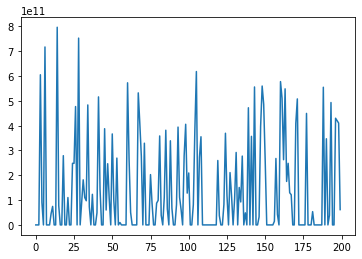

In [47]:
pd.DataFrame(log_detail)[1].plot()

<AxesSubplot:>

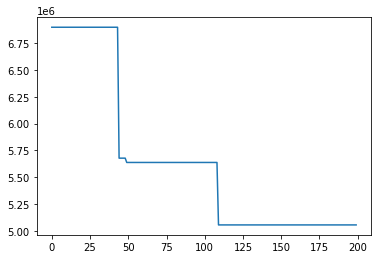

In [48]:
pd.DataFrame(log)[1].plot()

In [50]:
%%time
# number of generations
n_iter = 200
# define the population size
n_pop = 20
# crossover rate
r_cross = 0.4
# mutation rate
r_mut = 0.4 

best, score, log, log_detail = genetic_algorithm(mijt, n_iter, n_pop, r_cross, r_mut)
print('Done!')

253183284640


  0%|          | 0/200 [00:00<?, ?it/s]

>best! 0, 35711554370
>best! 0, 12034648
>best! 0, 9487338
>best! 0, 8947764
>best! 0, 7237612


  2%|▏         | 3/200 [00:08<09:34,  2.91s/it]

>best! 3, 6042290


  9%|▉         | 18/200 [00:52<08:42,  2.87s/it]

>best! 18, 4259831


 60%|█████▉    | 119/200 [05:46<03:56,  2.91s/it]

stop
Done!
CPU times: user 5min 46s, sys: 79.3 ms, total: 5min 46s
Wall time: 5min 46s


<AxesSubplot:>

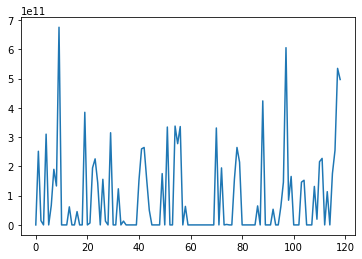

In [51]:
pd.DataFrame(log_detail)[1].plot()

<AxesSubplot:>

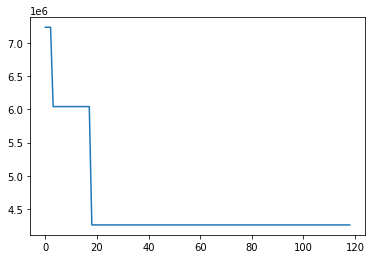

In [52]:
pd.DataFrame(log)[1].plot()

In [54]:
%%time
# number of generations
n_iter = 200
# define the population size
n_pop = 40
# crossover rate
r_cross = 0.4
# mutation rate
r_mut = 0.4 

best, score, log, log_detail = genetic_algorithm(mijt, n_iter, n_pop, r_cross, r_mut)
print('Done!')

10310840


  0%|          | 0/200 [00:00<?, ?it/s]

>best! 0, 6995462
>best! 0, 5949254


 44%|████▍     | 89/200 [08:34<10:41,  5.78s/it]

>best! 89, 5269082


 79%|███████▉  | 158/200 [15:12<04:02,  5.77s/it]

>best! 158, 5163674


100%|██████████| 200/200 [19:16<00:00,  5.78s/it]

Done!
CPU times: user 19min 16s, sys: 189 ms, total: 19min 16s
Wall time: 19min 16s


<AxesSubplot:>

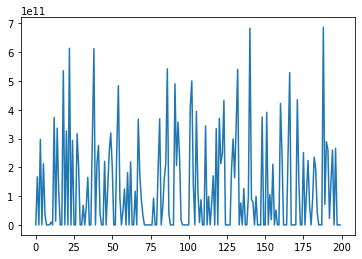

In [57]:
pd.DataFrame(log_detail)[1].plot()

<AxesSubplot:>

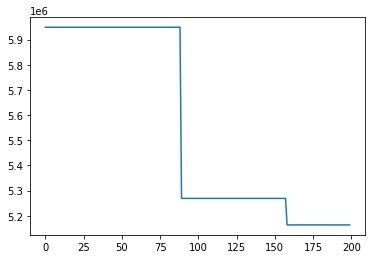

In [58]:
pd.DataFrame(log)[1].plot()

In [59]:
%%time
# number of generations
n_iter = 200
# define the population size
n_pop = 20
# crossover rate
r_cross = 0.2
# mutation rate
r_mut = 0.4 

best, score, log, log_detail = genetic_algorithm(mijt, n_iter, n_pop, r_cross, r_mut)
print('Done!')

11059463


  0%|          | 0/200 [00:00<?, ?it/s]

>best! 0, 6407683


 22%|██▏       | 43/200 [02:03<07:45,  2.96s/it]

>best! 43, 4587946


 72%|███████▏  | 144/200 [06:57<02:42,  2.90s/it]

stop
Done!
CPU times: user 6min 57s, sys: 180 ms, total: 6min 58s
Wall time: 6min 57s


<AxesSubplot:>

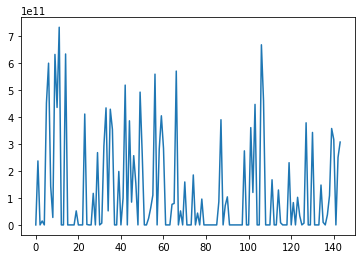

In [60]:
pd.DataFrame(log_detail)[1].plot()

<AxesSubplot:>

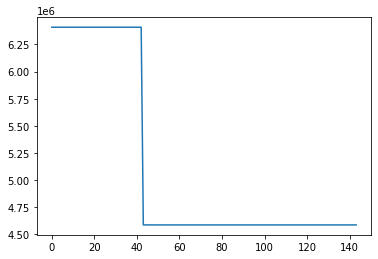

In [61]:
pd.DataFrame(log)[1].plot()

In [62]:
%%time
# number of generations
n_iter = 200
# define the population size
n_pop = 20
# crossover rate
r_cross = 0.4
# mutation rate
r_mut = 0.4 

best, score, log, log_detail = genetic_algorithm(mijt, n_iter, n_pop, r_cross, r_mut)
print('Done!')

12731853


  0%|          | 0/200 [00:00<?, ?it/s]

>best! 0, 8690670
>best! 0, 7782007


  2%|▏         | 4/200 [00:11<09:17,  2.85s/it]

>best! 4, 6448550


  4%|▍         | 8/200 [00:22<09:04,  2.84s/it]

>best! 8, 3592042


 55%|█████▍    | 109/200 [05:09<04:18,  2.84s/it]

stop
Done!
CPU times: user 5min 9s, sys: 40 ms, total: 5min 9s
Wall time: 5min 9s


<AxesSubplot:>

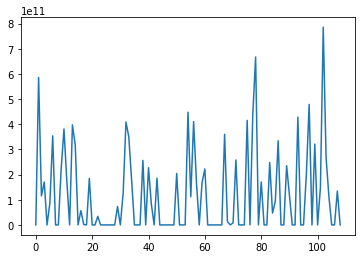

In [65]:
pd.DataFrame(log_detail)[1].plot()

<AxesSubplot:>

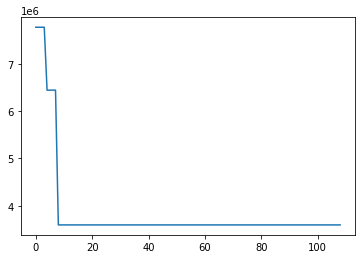

In [66]:
pd.DataFrame(log)[1].plot()

In [67]:
%%time
# number of generations
n_iter = 200
# define the population size
n_pop = 20
# crossover rate
r_cross = 0.3
# mutation rate
r_mut = 0.4 

best, score, log, log_detail = genetic_algorithm(mijt, n_iter, n_pop, r_cross, r_mut)
print('Done!')

399240197180


  0%|          | 0/200 [00:00<?, ?it/s]

>best! 0, 7515273


 46%|████▌     | 92/200 [04:22<05:08,  2.85s/it]

>best! 92, 7111069


 56%|█████▌    | 111/200 [05:16<04:14,  2.86s/it]

>best! 111, 4628599


100%|██████████| 200/200 [09:30<00:00,  2.85s/it]

Done!
CPU times: user 9min 30s, sys: 180 ms, total: 9min 30s
Wall time: 9min 30s


<AxesSubplot:>

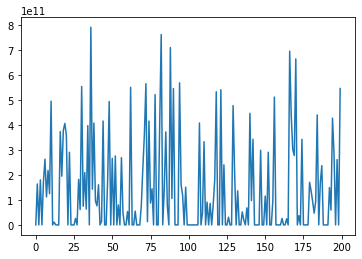

In [68]:
pd.DataFrame(log_detail)[1].plot()

<AxesSubplot:>

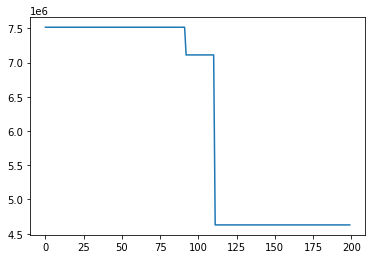

In [69]:
pd.DataFrame(log)[1].plot()

8289927


  0%|          | 0/200 [00:00<?, ?it/s]

>best! 0, 7133329
>best! 0, 5649580


 16%|█▋        | 33/200 [00:15<01:18,  2.12it/s]

>best! 33, 4787354


 67%|██████▋   | 134/200 [01:03<00:31,  2.09it/s]

stop
Done!
CPU times: user 1min 4s, sys: 80.1 ms, total: 1min 4s
Wall time: 1min 4s


<AxesSubplot:>

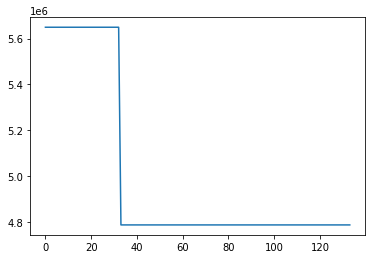

In [73]:
%%time
# number of generations
n_iter = 200
# define the population size
n_pop = 20
# crossover rate
r_cross = 0.4
# mutation rate
r_mut = 0.1

best, score, log, log_detail = genetic_algorithm(mijt, n_iter, n_pop, r_cross, r_mut)
print('Done!')
pd.DataFrame(log)[1].plot()

90894474660


  0%|          | 0/200 [00:00<?, ?it/s]

>best! 0, 45445816280
>best! 0, 6548603


 42%|████▏     | 83/200 [03:57<05:33,  2.85s/it]

>best! 83, 6336501


 51%|█████     | 102/200 [04:52<04:39,  2.85s/it]

>best! 102, 6190193


 72%|███████▎  | 145/200 [06:55<02:37,  2.87s/it]

>best! 145, 4326043


100%|██████████| 200/200 [09:35<00:00,  2.88s/it]

Done!
CPU times: user 9min 35s, sys: 150 ms, total: 9min 35s
Wall time: 9min 35s


<AxesSubplot:>

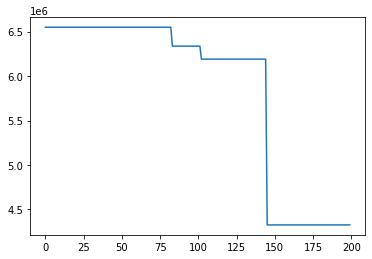

In [71]:
%%time
# number of generations
n_iter = 200
# define the population size
n_pop = 20
# crossover rate
r_cross = 0.1
# mutation rate
r_mut = 0.4

best, score, log, log_detail = genetic_algorithm(mijt, n_iter, n_pop, r_cross, r_mut)
print('Done!')
pd.DataFrame(log)[1].plot()

13079733


  0%|          | 0/100 [00:00<?, ?it/s]

>best! 0, 9020071
>best! 0, 6800715


  1%|          | 1/100 [00:05<09:33,  5.80s/it]

>best! 1, 6330234


 66%|██████▌   | 66/100 [06:16<03:14,  5.73s/it]

>best! 66, 4892312


100%|██████████| 100/100 [09:27<00:00,  5.68s/it]

Done!
CPU times: user 9min 27s, sys: 80 ms, total: 9min 27s
Wall time: 9min 27s


<AxesSubplot:>

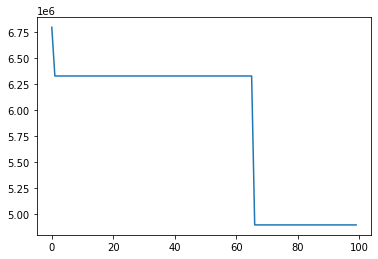

In [61]:
%%time
# number of generations
n_iter = 100
# define the population size
n_pop = 40
# crossover rate
r_cross = 0.4
# mutation rate
r_mut = 0.4

best, score, log, log_detail = genetic_algorithm(mijt, n_iter, n_pop, r_cross, r_mut)
print('Done!')
pd.DataFrame(log)[1].plot()

In [107]:
dit['K04033', '2021-05-13']
dit['K04031', '2021-05-24']
dit['051718', '2021-05-30']
dit['S00341', '2021-03-10']
dit['052996', '2021-02-18']
#dit['K04101', '2021-05-30']

2

In [62]:
solution_ = dict()
xijt = decode(mijt, xijt)
for i in I:
    for j in J:
        for t in T:
            solution_[i, j, t] = round(best[i, j, t]*dit[i, t])

sol = pd.DataFrame.from_dict(solution_, orient='index')
sol.to_csv('GA_solution.csv')
sol[sol[0]>0]

,0
"(052996, 410.0, 2021-05-30)",1
"(052996, 410.0, 2021-02-18)",1
"(052996, 421.0, 2021-05-30)",1
"(052996, 421.0, 2021-02-18)",1
"(K04033, 404.0, 2021-05-13)",194
"(K04033, 405.0, 2021-05-13)",268
"(K04033, 407.0, 2021-05-13)",210
"(K04033, 408.0, 2021-05-13)",238
"(K04033, 409.0, 2021-05-13)",199
"(K04033, 410.0, 2021-05-13)",124


In [63]:

i = '052996'
t = '2021-05-30'
total = 0
print(f'demand: {dit[i, t]}')
for j in J:
    if xijt[i,j,t]>0:
        value = round(xijt[i,j,t]*dit[i, t])
        print(f'machine {j}: {value}')
        total += value
print(f'total : {total}')

demand: 2
machine 410.0: 1
machine 421.0: 1
total : 2


In [64]:
i = 'K04101'
t = '2021-05-30'
total = 0
print(f'demand: {dit[i, t]}')
for j in J:
    if xijt[i,j,t]>0:
        value = round(xijt[i,j,t]*dit[i, t])
        print(f'machine {j}: {value}')
        total += value
print(f'total : {total}')

demand: 15
machine 408.0: 10
machine 409.0: 0
machine 416.0: 1
machine 424.0: 3
machine 425.0: 15
machine 426.0: 9
total : 38


In [65]:
i = 'K04033'
t = '2021-05-13'

total = 0
print(f'demand: {dit[i, t]}')
for j in J:
    if xijt[i,j,t]>0:
        value = round(xijt[i,j,t]*dit[i, t])
        print(f'machine {j}: {value}')
        total += value
print(f'total : {total}')

demand: 318
machine 404.0: 194
machine 405.0: 268
machine 407.0: 210
machine 408.0: 238
machine 409.0: 199
machine 410.0: 124
machine 412.0: 213
machine 416.0: 143
machine 422.0: 95
machine 424.0: 157
machine 426.0: 216
machine 433.0: 73
machine 434.0: 293
machine 435.0: 102
machine 436.0: 0
machine 438.0: 113
machine 439.0: 50
machine 440.0: 144
total : 2832


In [66]:
i = 'K04031'
t = '2021-05-24'

total = 0
print(f'demand: {dit[i, t]}')
for j in J:
    if xijt[i,j,t]>0:
        value = round(xijt[i,j,t]*dit[i, t])
        print(f'machine {j}: {value}')
        total += value
print(f'total : {total}')

demand: 383
machine 407.0: 200
machine 408.0: 267
machine 409.0: 275
machine 410.0: 178
machine 416.0: 281
machine 424.0: 367
machine 425.0: 110
machine 426.0: 72
machine 433.0: 23
machine 434.0: 207
machine 435.0: 263
machine 436.0: 72
machine 440.0: 230
total : 2545


In [67]:
i = '052996'
t = '2021-02-18'

total = 0
print(f'demand: {dit[i, t]}')
for j in J:
    if xijt[i,j,t]>0:
        value = round(xijt[i,j,t]*dit[i, t])
        print(f'machine {j}: {value}')
        total += value
print(f'total : {total}')

demand: 2
machine 410.0: 1
machine 421.0: 1
total : 2
